### Grading
This week's lab doesn't have any auto-graded components. Each question in this notebook has an accompanying Peer Review question. Although the lab shows as being ungraded, you need to complete the notebook to answer the Peer Review questions. <br>
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** 

### Validate Button
This week's lab doesn't have any auto-graded components. Each question in this notebook has an accompanying Peer Review question. Although the lab shows as being ungraded, you need to complete the notebook to answer the Peer Review questions. 

You do not need to use the Validate button for this lab since there are no auto-graded components. If you hit the Validate button, it will time out given the number of visualizations in the notebook. Cells with longer execution times cause the validate button to time out and freeze. ***This notebook's Validate button time-out does not affect the final submission grading.*** 

# Clustering RNA sequences to identify cancer types

In this assignment, we will use clustering algorithms on RNA sequence data to identify cancer types.
Since the [whole data](https://www.synapse.org/#!Synapse:syn4301332) (from [Cancer Genome Atlas Pan-Cancer project](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3919969/)) is very big, we will use a [subset data from UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#). The subset data contains only 5 labels; BRCA, KIRC, COAD, LUAD and PRAD. The meanings of those labels are as below.

|Abbreviation|Cancer|
|:----:|:-------:|
|LUSC|Lung squamous cell carcinoma |
|READ |Rectum adenocarcinoma |
|GBM |Glioblastoma multiforme|
|BLCA |Bladder Urothelial Carcinoma|
|UCEC |Uterine Corpus Endometrioid Carcinoma|
|COAD |Colon adenocarcinoma|
|OV |Ovarian serous cystadenocarcinoma|
|LAML |Acute Myeloid Leukemia|
|HNSC |Head and Neck squamous cell carcinoma|
|LUAD |Lung adenocarcinoma|
|BRCA |Breast invasive carcinoma|
|KIRC |Kidney renal clear cell carcinoma|

Although we can use the data for supervised learning model training, we will not use these labels for training, but use them for evaluation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import time

In [2]:
# Read data. Do not change the variable names (data, label)
data = pd.read_csv('data/data.csv')
label = pd.read_csv('data/labels.csv')
data=data.drop('Unnamed: 0',axis=1)
label=label.drop('Unnamed: 0',axis=1)

### A. [Peer Review] Perform basic data inspection or EDA on the pandas dataframe.
- How many observations?
- How many features?

In [51]:
# perform basic data inspection such as getting the number of observations and number of features
# you can also display part of the dataframe or run data.info() 
# your code here
num_observations = data.shape[0]
num_features = data.shape[1]
print(f'Number of observations: {num_observations}')
print(f'Number of features: {num_features}')

print(data.head())
print(label.head())

print(data.shape)
print(label.shape)
print( label['Class'].unique() )

Number of observations: 801
Number of features: 20531
   gene_0    gene_1    gene_2    gene_3     gene_4  gene_5    gene_6  \
0     0.0  2.017209  3.265527  5.478487  10.431999     0.0  7.175175   
1     0.0  0.592732  1.588421  7.586157   9.623011     0.0  6.816049   
2     0.0  3.511759  4.327199  6.881787   9.870730     0.0  6.972130   
3     0.0  3.663618  4.507649  6.659068  10.196184     0.0  7.843375   
4     0.0  2.655741  2.821547  6.539454   9.738265     0.0  6.566967   

     gene_7  gene_8  gene_9  ...  gene_20521  gene_20522  gene_20523  \
0  0.591871     0.0     0.0  ...    4.926711    8.210257    9.723516   
1  0.000000     0.0     0.0  ...    4.593372    7.323865    9.740931   
2  0.452595     0.0     0.0  ...    5.125213    8.127123   10.908640   
3  0.434882     0.0     0.0  ...    6.076566    8.792959   10.141520   
4  0.360982     0.0     0.0  ...    5.996032    8.891425   10.373790   

   gene_20524  gene_20525  gene_20526  gene_20527  gene_20528  gene_20529  \
0  

- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What do those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.) <br>
Answer the Peer Review question about this section. 

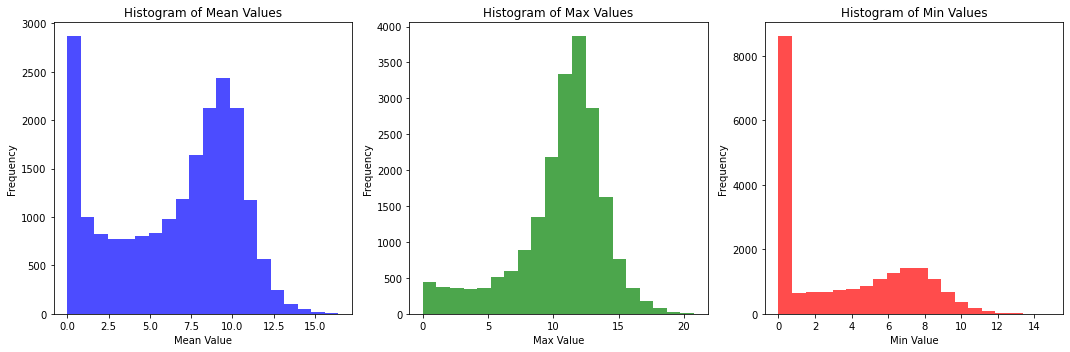

In [68]:
# draw histograms of mean, max and min values in each feature 
# your code here
np_data = data.to_numpy()
feature_means = data.mean()
feature_maxs = data.max()
feature_mins = data.min()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(feature_means, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Mean Values')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(feature_maxs, bins=20, color='green', alpha=0.7)
plt.title('Histogram of Max Values')
plt.xlabel('Max Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(feature_mins, bins=20, color='red', alpha=0.7)
plt.title('Histogram of Min Values')
plt.xlabel('Min Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


- If we were to train a "supervised" learning model, how would you deal with such large feature dimension? 
- Even after feature dimension reduction, still the number of useful features may be enormous. How it would impact performance or runtime of certain supervised learning algorithms? Which algorithms would suffer from high dimension features than others and why? 
- How it would impact performance or runtime of an unsupervised learning algorithm?
- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.) <br> <br>
Anwer these questions in this week's Peer Review assignment. 

### B. [Peer Review] Build a hierarchical clustering model
Let's build a model using hierarchical clustering. Hierarchical clustering module is available from `sklearn.cluster.AgglomerativeClustering`. You can choose linkage type and metric. Please check its documentation for more details.

**a) Number of clusters vs distance threshold**
Oftentimes hierarchical clustering does not need to know the number of clusters in advance. Instead, one needs to choose threshold distance/similarity to cut the dendrogram later. The AgglomerativeClustering module lets you specify either the number of clusters (n_clusters) or the threshold (distance_threshold). Based on our data, which should we choose to set to which value and why? <br> <br>
Answer this question in the Peer Review assignment. 

#### b) Guess which metric?
Can you guess which metric to use (distance-based vs. similarity-based) and why? 
This question is not graded, but we encourage you to share your thoughts with the class. See the ungraded discussion prompt for this week's material. 

#### c) Build a model
Build a model using n_clusters=5 option. Choose any metric and linkage type at first. Display the clustering result labels (you can just print out the result). Do not change the variable (model) name. Answer the question about this section in the Peer Review.

In [57]:
# build a model using n_clusters=5 option
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
labels = model.fit_predict(data)
print(labels)
print( sum(model.labels_ == labels) / len(labels) )


[2 3 2 2 0 2 1 2 0 2 0 1 2 0 0 0 3 1 1 2 0 1 3 0 1 3 4 0 0 0 0 0 1 0 2 0 1
 3 0 0 1 2 2 1 1 0 2 4 0 3 0 3 0 2 4 0 0 4 1 0 3 1 0 3 2 4 0 2 1 0 1 0 0 3
 0 3 0 1 2 4 0 2 0 0 2 2 0 0 1 0 2 2 0 0 0 2 4 0 2 0 0 1 0 1 3 1 3 4 3 3 2
 0 3 2 0 1 1 1 0 0 3 1 3 0 2 2 2 0 1 0 4 0 4 0 0 1 3 0 1 4 0 2 0 1 3 4 2 0
 3 3 3 3 0 0 3 0 0 2 2 3 2 3 1 0 2 3 4 1 3 0 1 3 0 3 0 0 0 2 0 1 4 1 0 2 2
 2 3 3 0 3 3 1 3 2 3 0 0 0 3 3 0 1 1 1 1 2 0 2 0 3 3 0 2 0 2 0 0 0 3 0 1 3
 1 1 3 0 1 2 0 3 3 2 4 0 1 2 1 4 0 1 1 3 2 2 3 3 1 0 0 4 0 2 4 0 2 1 2 2 2
 0 4 4 3 4 4 2 3 0 0 1 1 0 4 2 1 2 0 0 1 0 0 0 0 3 3 0 0 0 1 1 1 1 0 0 0 1
 0 0 3 2 0 0 4 3 2 0 0 0 4 0 2 0 4 3 3 2 1 0 1 1 3 4 1 0 0 0 0 1 0 0 2 0 1
 0 3 2 1 0 2 4 0 0 0 3 3 3 0 0 2 3 0 1 0 4 4 3 0 1 0 0 0 4 3 4 1 2 1 0 0 1
 0 4 2 3 2 0 1 2 0 4 1 1 4 4 2 0 0 4 1 3 2 0 0 0 3 3 1 3 0 1 4 2 0 3 2 0 0
 0 3 0 0 2 0 2 4 0 3 0 0 3 0 0 0 1 3 2 0 2 1 0 1 4 0 2 3 1 0 0 1 0 3 0 0 2
 4 0 1 3 2 0 2 0 0 0 0 1 3 0 1 0 0 3 3 1 4 2 4 0 1 1 0 2 1 4 3 3 0 2 2 0 2
 3 1 2 0 3 2 3 0 0 4 3 1 

#### d) Label permuation
In clustering, the labels get assigned randomly, so the label numbering won't match the ground truth necessarily. Write a function below to find best matching label ordering based on the accuracy. Do not change the variable names. Answer the question about this section in the Peer Review. 

In [58]:
import itertools
import numpy as np
from sklearn.metrics import accuracy_score

def label_permute_compare(ytdf, yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns the best permuted label order and its corresponding accuracy.
    Example output: ({3: 0, 4: 1, 1: 2, 2: 3}, 0.74)
    """
    np_labels = ytdf.to_numpy().flatten()
    # print(np_labels)
    
    # Get unique true labels and their counts
    true_labels, true_counts = np.unique(np_labels, return_counts=True)
    
    # Get unique predicted labels and their counts
    pred_labels, pred_counts = np.unique(yp, return_counts=True)
    
    # Generate permutations of the predicted labels
    best_accuracy = 0
    best_mapping = {}
    
    for perm in itertools.permutations(pred_labels):
        # Create a mapping from true labels to the permuted predicted labels
        mapping = dict(zip(true_labels, perm))
        
        # Standardize np_labels using the mapping
        new_labels = np.vectorize(mapping.get)(np_labels)
        # print(new_labels)
        
        # Compute accuracy
        accuracy = accuracy_score(new_labels, yp)
        
        # Update best mapping and accuracy if current accuracy is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = mapping
    
    return best_mapping, best_accuracy


In [59]:
labelorder, acc = label_permute_compare(label, model.labels_)
print(labelorder, acc)

{'BRCA': 0, 'COAD': 4, 'KIRC': 1, 'LUAD': 3, 'PRAD': 2} 0.9950062421972534


#### e) Check confusion matrix
Use sklearn's confusion matrix and display the results. Answer the Peer Review question about this section.  

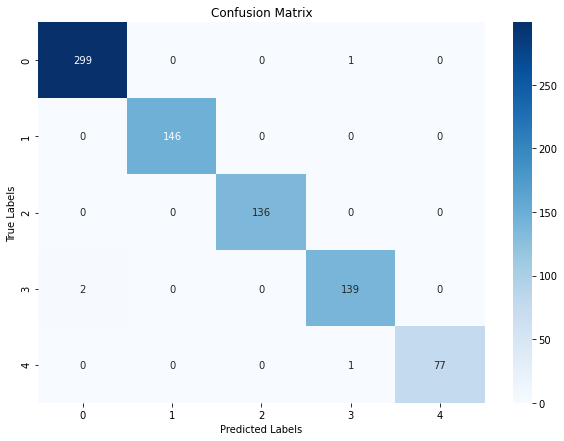

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(label_df, predicted_labels):
    """
    Plots the confusion matrix using seaborn.
    
    true_labels: array-like, shape (n_samples,) - Ground truth (correct) labels.
    predicted_labels: array-like, shape (n_samples,) - Predicted labels, as returned by a classifier.
    """
    # Get labels
    best_mapping, best_accuracy = label_permute_compare(label_df, predicted_labels)
    # Compute confusion matrix
    true_labels = np.vectorize(best_mapping.get)(np_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 7))
    
    # Create a heatmap with annotations
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(len(np.unique(true_labels))), 
                yticklabels=range(len(np.unique(true_labels))))
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


plot_confusion_matrix( label, model.labels_ )

#### f) Change linkage method and distance metric. Which ones lead the best performance? Print out the accuracy and confusion matrix for the best model.
<br> Answer the Peer Review questions about this section. 

In [63]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering

def evaluate_agglomerative_clustering(np_data, true_labels):
    """
    Evaluates different distance metrics and linkage methods for Agglomerative Clustering.

    np_data: Input data for clustering (numpy array).
    true_labels: Ground truth labels (DataFrame or Series).
    
    Returns a dictionary containing the best model's accuracy, metric, and linkage.
    """
    metrics_to_try = ["euclidean", "l1", "l2", "manhattan", "cosine"]
    linkages_to_try = ["complete", "average", "single"]
    options = list(
        itertools.product(metrics_to_try, linkages_to_try)
    ) + [ ("euclidean", "ward") ]
    
    best_model = None
    best_accuracy = 0
    best_metric = "euclidean"
    best_linkage = "ward"

    for (metric, linkage) in options:
        model = AgglomerativeClustering(n_clusters=5, affinity=metric, linkage=linkage)
        model.fit(np_data)
        mapping, accuracy = label_permute_compare(true_labels, model.labels_)

        print(f'The model with distance metric "{metric}" and linkage "{linkage}" yielded an accuracy of {accuracy:.4f}')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_metric = metric
            best_linkage = linkage
            best_model = model

    result = {
        'best_model': best_model,
        'best_accuracy': best_accuracy,
        'best_metric': best_metric,
        'best_linkage': best_linkage
    }

    print(f'The best model had metric "{best_metric}" and linkage "{best_linkage}". It had an accuracy of {best_accuracy:.4f}')

    return result

# Example usage
result = evaluate_agglomerative_clustering(data, label)

The model with distance metric "euclidean" and linkage "complete" yielded an accuracy of 0.9313
The model with distance metric "euclidean" and linkage "average" yielded an accuracy of 0.3645
The model with distance metric "euclidean" and linkage "single" yielded an accuracy of 0.3758
The model with distance metric "l1" and linkage "complete" yielded an accuracy of 0.7228
The model with distance metric "l1" and linkage "average" yielded an accuracy of 0.3658
The model with distance metric "l1" and linkage "single" yielded an accuracy of 0.3745
The model with distance metric "l2" and linkage "complete" yielded an accuracy of 0.9313
The model with distance metric "l2" and linkage "average" yielded an accuracy of 0.3645
The model with distance metric "l2" and linkage "single" yielded an accuracy of 0.3758
The model with distance metric "manhattan" and linkage "complete" yielded an accuracy of 0.7228
The model with distance metric "manhattan" and linkage "average" yielded an accuracy of 0.3

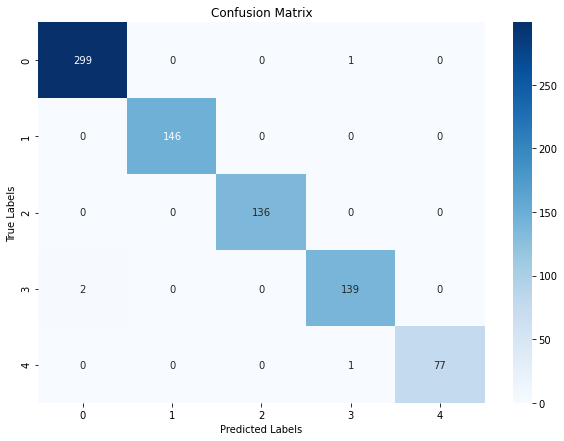

In [64]:
plot_confusion_matrix( label, result['best_model'].labels_ )

### C. What about k-means clustering?
Can we apply kmeans clustering on this data? Which clustering methods give a better performance? Is kmeans faster or slower?

In [71]:
# try to apply kmeans clustering on this data
# time kmeans to compare to hierarchical clustering 
# your code here

# time kmeans to compare to hierarchical clustering 
from sklearn.cluster import KMeans
import time


def evaluate_kmeans(np_data, true_labels):
    """
    Evaluates KMeans clustering with different algorithms and initialization methods.

    np_data: Input data for clustering (numpy array).
    true_labels: Ground truth labels (DataFrame or Series).
    
    Returns the best KMeans model and its accuracy.
    """
    alg_to_try = ["elkan", "auto"]
    init_to_try = ["random", "k-means++"]
    
    current_best_acc = 0
    best_model_info = {}

    for alg, init in itertools.product(alg_to_try, init_to_try):
        this_kmeans = KMeans(n_clusters=5, random_state=21, init=init, algorithm=alg)
        
        start_time = time.time()
        this_kmeans.fit(np_data)
        elapsed_time = time.time() - start_time
        
        this_accuracy = label_permute_compare(true_labels, this_kmeans.labels_)[1]
        
        print(f'The model with algorithm "{alg}" and centroid initialization "{init}" yielded an accuracy of {this_accuracy:.4f} (Time: {elapsed_time:.4f}s)')
        
        if this_accuracy > current_best_acc:
            current_best_acc = this_accuracy
            best_model_info = {
                'best_model': this_kmeans,
                'best_accuracy': current_best_acc,
                'best_algorithm': alg,
                'best_init': init,
                'elapsed_time': elapsed_time
            }

    print(f'The best KMeans Clustering Model had algorithm "{best_model_info["best_algorithm"]}" and centroid initialization "{best_model_info["best_init"]}".')
    print(f'It had an accuracy of {best_model_info["best_accuracy"]:.4f} and took {best_model_info["elapsed_time"]:.4f} seconds.')

    return best_model_info

# Example usage
best_kmeans_info = evaluate_kmeans(np_data, label)


The model with algorithm "elkan" and centroid initialization "random" yielded an accuracy of 0.9938 (Time: 6.9579s)
The model with algorithm "elkan" and centroid initialization "k-means++" yielded an accuracy of 0.9925 (Time: 10.2467s)
The model with algorithm "auto" and centroid initialization "random" yielded an accuracy of 0.9938 (Time: 6.9856s)
The model with algorithm "auto" and centroid initialization "k-means++" yielded an accuracy of 0.9925 (Time: 10.3627s)
The best KMeans Clustering Model had algorithm "elkan" and centroid initialization "random".
It had an accuracy of 0.9938 and took 6.9579 seconds.


In [72]:
# Initialize Agglomerative Clustering
agglo_clustering = AgglomerativeClustering(n_clusters=5)

# Measure training time
start_time = time.time()
agglo_clustering.fit(np_data)
end_time = time.time()

# Calculate total training time
total_training_time = end_time - start_time
print(f'The total training time for the Agglomerative Clustering model was {total_training_time:.4f} seconds')


The total training time for the Agglomerative Clustering model was 6.3648 seconds
